In [1]:
import json
# import ast

import pandas as pd
from pandarallel import pandarallel
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # to manipulate x-tickers
import plotly.express as px
import torch
import os
from tqdm import tqdm
import pickle
import warnings
from collections import Counter
from transformers import AutoTokenizer
from Levenshtein import distance as lev_distance

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize': (20, 10), 'figure.facecolor': 'white'})
sns.set_palette("viridis")
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
os.environ["TOKENIZERS_PARALLELISM"] = "true"  # activate parallelism
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [58]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"  # show all outputs, not only the last one

In [45]:
import sqlite3


def read_from_db(query):
    conn = sqlite3.connect("../data/processed/recipies.db")
    df = pd.read_sql(query, conn)
    return df


read_from_db(
    """
    select  *
    from    products
    """
)

,id,product,qnt,occurrence_in_recipies
0,0,соль,78056,0.532511
1,1,яйцо куриное,58219,0.397180
2,2,мука пшеничная,50689,0.345809
3,3,сахар,50580,0.345065
4,4,лук репчатый,40855,0.278720
...,...,...,...,...
1093,1093,творог жирный,1,0.000007
1094,1094,сметанка,1,0.000007
1095,1095,желтки яичные,1,0.000007
1096,1096,изюм без косточек,1,0.000007


In [39]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print("MPS device not found.")

In [2]:
data = pd.read_csv("../data/raw/povarenok_recipes_2021_06_16.csv").drop(columns=['url']).dropna(subset=['ingredients'])
data

,name,ingredients
0,Густой молочно-клубничный коктейль,"{'Молоко': '250 мл', 'Клубника': '200 г', 'Сахар': '15 г'}"
1,Рулетики,"{'Сыр твердый': None, 'Чеснок': None, 'Яйцо куриное': None, 'Грейпфрут': None, 'Лук зеленый': None, 'Листья салата': None, 'Майонез': None}"
2,"Салат ""Баклажанчик""","{'Баклажан': '3 шт', 'Лук репчатый': '2 шт', 'Помидор': '2 шт', 'Чеснок': '1 зуб.', 'Соль': None, 'Майонез': None, 'Перец черный': None}"
3,Куриные котлеты с картофельным пюре в духовке,"{'Фарш куриный': '800 г', 'Пюре картофельное': '1 кг', 'Желток яичный': '1 шт', 'Лук репчатый': '1 шт', 'Сыр твердый': '150 г', 'Молоко': '50 мл', 'Масло сливочное': '30 г', 'Зелень': '0,5 пуч.', 'Приправа': '1,5 ч. л.', 'Масло растительное': '5 ст. л.'}"
4,Рецепт вишневой наливки,"{'Вишня': '1 кг', 'Водка': '1 л', 'Сахар': '300 г', 'Кости': '50 г', 'Корица': '8 г', 'Гвоздика': '3 шт'}"
...,...,...
146577,"Украшение для блюд ""Снежинка""","{'Капуста краснокочанная': None, 'Капуста белокочанная': None}"
146578,Греческий рисовый пирог с фаршем,"{'Фарш мясной': '400 г', 'Масло сливочное': '2 ст. л.', 'Соль': '1 ч. л.', 'Перец черный': None, 'Розмарин': '0.5 ч. л.', 'Чеснок': '2 зуб.', 'Вино белое сухое': '150 мл', 'Помидор': '2 шт', 'Рис': '1 стак.', 'Оливки черные': '10 шт', 'Фета': '200 г', 'Яйцо куриное': '1 шт', 'Тесто слоеное': '300 г', 'Петрушка': '1 пуч.'}"
146579,Соус на груздях с хреном,"{'Грибы': '300 г', 'Чеснок': '5 зуб.', 'Лук репчатый': '2 шт', 'Сметана': '1 стак.', 'Хрен': '50 г', 'Петрушка': '1 пуч.', 'Лук зеленый': '1 пуч.', 'Сухари панировочные': '1 горст.', 'Мука пшеничная': '1 горст.'}"
146580,Печенье со сливочным сыром,"{'Масло сливочное': '225 г', 'Сыр сливочный': '225 г', 'Сахар': '1 стак.', 'Яйцо куриное': '2 шт', 'Мука пшеничная': '420 г', 'Разрыхлитель теста': '1 ч. л.', 'Ванильная эссенция': '2 ч. л.', 'Соль': '1 ч. л.'}"


# Get Embeddings

Bert Encoders comparison

In [3]:
print("'ai-forever/sbert_large_nlu_ru' Tokenizer: ",
      AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru").tokenize(["молоко", "сахар"]))
print("'bert-base-multilingual-uncased' Tokenizer: ",
      AutoTokenizer.from_pretrained("bert-base-multilingual-uncased").tokenize(["молоко", "сахар"]))

'ai-forever/sbert_large_nlu_ru' Tokenizer:  ['молоко', 'сахар']
'bert-base-multilingual-uncased' Tokenizer:  ['мо', '##лок', '##о', 'са', '##ха', '##р']


As we can see above, Tokenizer "bert-base-multilingual-uncased" splits Russian words the strange way (checked with the tokenize() method), so we will go with "ai-forever/sbert_large_nlu_ru" that yields all in all satisfactory results

In [4]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
tokenizer

BertTokenizerFast(name_or_path='ai-forever/sbert_large_nlu_ru', vocab_size=120138, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [5]:
tokenizer(['молоко', 'клубника', 'сахар'])

{'input_ids': [[101, 17066, 102], [101, 4378, 1032, 102], [101, 14500, 102]], 'token_type_ids': [[0, 0, 0], [0, 0, 0, 0], [0, 0, 0]], 'attention_mask': [[1, 1, 1], [1, 1, 1, 1], [1, 1, 1]]}

In [6]:
test_json = data.iloc[0, 1]


def json_to_norm_list(input_json):
    import ast
    norm_json = ast.literal_eval(input_json)  # json normalization
    return [el.lower() for el in norm_json]


json_to_norm_list(test_json)

['молоко', 'клубника', 'сахар']

In [7]:
def make_embeddings_list(ingredients_list: list):
    return [tokenizer(el).input_ids for el in ingredients_list]


make_embeddings_list(['молоко', 'клубника', 'сахар'])

[[101, 17066, 102], [101, 4378, 1032, 102], [101, 14500, 102]]

# Get common ingredients

In [8]:
# def get_common_ingredients():
#     pass

In [36]:
ingredients_all = data.ingredients.parallel_apply(lambda x: json_to_norm_list(x))

In [33]:
def flatter_lists(l):
    return [item for sublist in l for item in sublist]


products_freq = pd.DataFrame.from_records(Counter(flatter_lists(ingredients_all)).most_common(),
                                          columns=['product', 'qnt'])
products_freq['occurrence_in_recipies'] = products_freq['qnt'] / len(data)
products_freq

,product,qnt,occurrence_in_recipies
0,соль,78056,0.532511
1,яйцо куриное,58219,0.397180
2,мука пшеничная,50689,0.345809
3,сахар,50580,0.345065
4,лук репчатый,40855,0.278720
...,...,...,...
1093,творог жирный,1,0.000007
1094,сметанка,1,0.000007
1095,желтки яичные,1,0.000007
1096,изюм без косточек,1,0.000007


In [11]:
products_freq_plot = (
    products_freq
    .sort_values(by='occurrence_in_recipies')
    .reset_index(drop=True)
    .assign(accumulative_probability=lambda df_: (df_.index + 1) * (1 / len(df_)))
    .groupby('occurrence_in_recipies', as_index=False)
    .accumulative_probability
    .max()
)
products_freq_plot

,occurrence_in_recipies,accumulative_probability
0,0.000007,0.113843
1,0.000014,0.140255
2,0.000020,0.161202
3,0.000027,0.169399
4,0.000034,0.186703
...,...,...
514,0.278720,0.996357
515,0.345065,0.997268
516,0.345809,0.998179
517,0.397180,0.999089


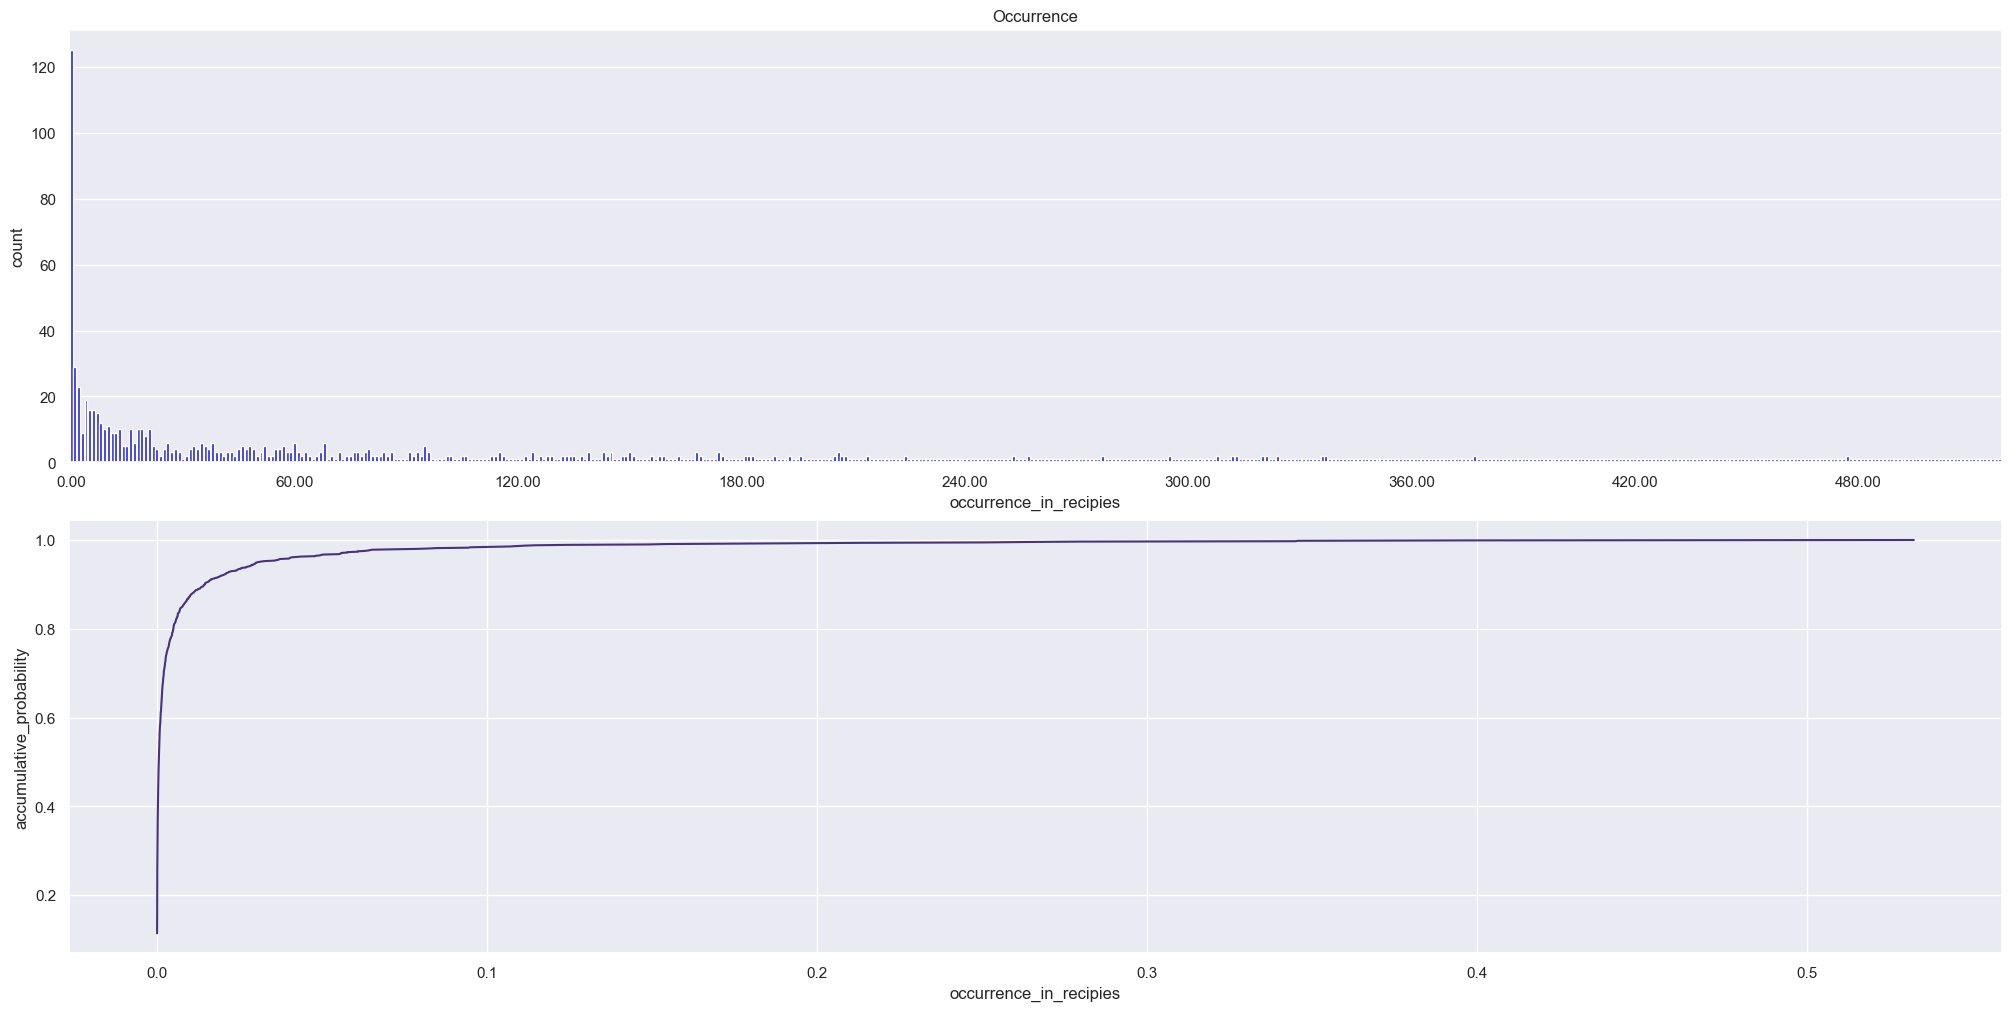

In [12]:
fig = plt.figure(layout="constrained")
ax = fig.subplot_mosaic("""
    AA
    BB
""")
sns.countplot(data=products_freq, x='occurrence_in_recipies', color='blue', ax=ax['A']).set_title('Occurrence')
ax['A'].xaxis.set_major_locator(ticker.MaxNLocator(10))
ax['A'].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
sns.lineplot(products_freq_plot, x='occurrence_in_recipies', y='accumulative_probability', ax=ax['B'])
plt.show()

Threshold 1% seems reasonable to recognize element as widely used and thus available on the average kitchen

In [13]:
common_ingredients = products_freq.query("occurrence_in_recipies >= 0.01")['product'].to_list()

# Search matching recipies

In [14]:
input = ['клубника', 'помидор', 'грейпфрут']

In [15]:
make_embeddings_list(input)

[[101, 4378, 1032, 102],
 [101, 79087, 102],
 [101, 3001, 378, 58057, 19961, 102]]

In [16]:
(np.array(tokenizer('клубника, помидор, грейпфрут').input_ids)).dot(
    np.array(tokenizer('клубника, помидор, грейпфрут').input_ids).T).ravel()

array([10053241019])

In [17]:
tokenizer('клубника, помидор, грейпфрут').input_ids

[101, 4378, 1032, 121, 79087, 121, 3001, 378, 58057, 19961, 102]

In [40]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device=device)
emb1 = model.encode('клубника, помидор, грейпфрут', convert_to_tensor=True)
emb2 = model.encode('клубниas', convert_to_tensor=True)
emb1.dot(emb2.T)

tensor(0.7211, device='mps:0')

In [19]:
emb2.size()

torch.Size([384])

let's try pooling

In [20]:
# token max length is
max_length = 0
for word in products_freq['product'].to_list():
    max_length = max(max_length, len(word))
    if len(word) == max_length:
        lengthy_word = word
max_length

35

In [21]:
db_products = products_freq.reset_index().rename(columns={'index': 'id'})
db_products

,id,product,qnt,occurrence_in_recipies
0,0,соль,78056,0.532511
1,1,яйцо куриное,58219,0.397180
2,2,мука пшеничная,50689,0.345809
3,3,сахар,50580,0.345065
4,4,лук репчатый,40855,0.278720
...,...,...,...,...
1093,1093,творог жирный,1,0.000007
1094,1094,сметанка,1,0.000007
1095,1095,желтки яичные,1,0.000007
1096,1096,изюм без косточек,1,0.000007


In [56]:
l = 'Молоко, Клубника Сахар'
import re

re.split('; |, |\;|\n|\\s', l)

['Молоко', 'Клубника', 'Сахар']

In [46]:
%%time
logging = []
matches = []
# is it cooler to weight lev distance on the distance of "mistapped" letter based on the closeness on the keyboard
for ingr in ['Молоко', 'Клубника', 'Сахар']:
    closest_match_id = db_products['product'].apply(lambda x: lev_distance(x, ingr)).sort_values().index[0]
    closest_match_name = db_products.iloc[closest_match_id]['product']
    matches.append(closest_match_id)
    logging.append((closest_match_id, closest_match_name))
matches

CPU times: user 2.54 ms, sys: 1.68 ms, total: 4.22 ms
Wall time: 3.51 ms


[10, 112, 3]

In [23]:
int(db_products[db_products['product'] == 'соль'].id)

0

In [24]:
def get_ingredients_ids(j):
    l = json_to_norm_list(j)
    result = []
    for el in l:
        result.append(int(db_products[db_products['product'] == el].id))
    return result


get_ingredients_ids("{'Молоко': '250 мл', 'Клубника': '200 г', 'Сахар': '15 г'}")

[10, 112, 3]

In [25]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [62]:
# create table with ingredients
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
db_ingredients = data.copy().reset_index(drop=True)
db_ingredients['embedding'] = db_ingredients['name'].apply(lambda x: model.encode(x, convert_to_tensor=True).numpy())
# db_ingredients['embedding'] = db_ingredients['name'].parallel_apply(lambda x: model.encode(x, convert_to_tensor=True))
db_ingredients = db_ingredients.reset_index().rename(columns={'index': 'id'})
db_ingredients['ingredients_ids'] = db_ingredients['ingredients'].parallel_apply(lambda x: get_ingredients_ids(x))
db_ingredients['ingredients_qnt'] = db_ingredients['ingredients_ids'].parallel_apply(lambda x: len(x))
db_ingredients


KeyboardInterrupt



In [ ]:
# db_ingredients.to_pickle("db_ingredients_backup.pkl")

In [ ]:
def dummy(l):
    cntr = 0
    for el in l:
        if el in matches:
            cntr += 1
    return cntr == len(matches)

In [ ]:
def general(l):
    cntr = 0
    for el in l:
        if el in matches or el in common_ingredients:
            cntr += 1
    return cntr == len(l)

In [ ]:
# recipies search
def get_matching_recipies(df_orig: pd.DataFrame, text_description=None):
    # think of sorting strategy; for now based on the amount of ingredients
    df = (
        df_orig
        .copy()
        .assign(is_match=lambda df_: df_.ingredients_ids.apply(lambda x: dummy(x)))
        .query("is_match")
        .dropna()
        .assign(is_full_match=lambda df_: df_.ingredients_ids.apply(lambda x: dummy(x)))
        .query("is_full_match")
        .dropna()
        .sort_values(by='ingredients_qnt')
        .reset_index(drop=True)
        .drop(columns=['is_match', 'is_full_match'])
        .head(10)
    )
    return df


get_matching_recipies(db_ingredients)

In [4]:
import sqlite3
def read_from_db(query):
    conn = sqlite3.connect("../data/processed/scoop.db")
    df = pd.read_sql(query, conn)
    return df

In [30]:
read_from_db(
    """
    select  *
    from    recipies
    """
)

DatabaseError: Execution failed on sql '
    select  *
    from    recipies
    ': no such table: recipies

In [29]:
print("Describe what dish you would want to cook | your mood | anything you want to \N{hugging face}")

Describe what dish you would want to cook | your mood | anything you want to 🤗


In [2]:
pd.read_pickle("../modules/desperate_backup.pkl")

,id,name,ingredients,embedding,ingredients_ids,ingredients_qnt
0,0,Густой молочно-клубничный коктейль,"{'Молоко': '250 мл', 'Клубника': '200 г', 'Сахар': '15 г'}","[0.028138611, 0.05334805, -0.04050061, 0.03788323, 0.0010132558, 0.05941749, 0.15265788, -0.022129187, -0.01445999, -0.07690136, -0.0043171323, 0.046877317, 0.045182567, 0.094008155, -0.015804306, -0.070950605, -0.022804292, 0.008848738, -0.058401294, -0.016437547, -0.009475474, -0.02397837, 0.077328004, 0.07003381, -0.006411259, 0.0060352976, -0.018034915, -0.048367895, 0.016808143, 0.055888925, -0.0064081997, 0.04482784, 0.042748496, -0.032037646, 0.010899452, 0.02667349, -0.0001526508, -0.034800477, 0.037172914, -3.6629164e-05, -0.05960539, -0.124611974, -0.0655171, 0.08263096, -0.0009618778, 0.044775575, -0.11311072, 0.0037687577, 0.053785753, 0.006915451, -0.09528918, -0.059481826, -0.021102993, 0.059450444, 0.0606929, -0.11194648, -0.09195145, 0.026921008, -0.007125453, -0.05641654, 0.040101625, 0.015710523, -0.05217109, 0.007577642, -0.020792622, -0.04248958, 0.03624654, -0.021506252, -0.019442085, 0.07602207, 0.057830337, -0.007286126, -0.06857161, 0.07105349, -0.03435586, -0.092647575, -0.06397541, 0.010508076, -0.033361785, -0.012622019, 0.035784695, 0.010009778, -0.08532063, -0.020815667, -0.0980175, -0.035787508, 0.050943647, -0.007028762, -0.018609768, 0.046127558, 0.013678138, 0.055459958, 0.057918962, -0.0067516267, -0.017918233, -0.045960877, -0.108963564, 0.010452546, 0.031217625, 0.014377222, ...]","[10, 112, 3]",3
1,1,Рулетики,"{'Сыр твердый': None, 'Чеснок': None, 'Яйцо куриное': None, 'Грейпфрут': None, 'Лук зеленый': None, 'Листья салата': None, 'Майонез': None}","[0.0069876113, 0.06731211, -0.06258901, 0.076143384, -0.042072803, 0.013866351, 0.09490333, 0.06460626, 0.025991362, -0.042280693, 0.029982692, -0.0018106626, 0.07887928, 0.07614063, -0.049815927, -0.059002742, 0.017856108, 0.065013416, -0.077121764, -0.047193997, -0.005365962, -0.04300064, 0.09527427, 0.059695132, 0.03938677, 0.044349182, 0.046936095, -0.020444058, 0.034051478, 0.0038372648, -0.0048911218, -0.03809387, -0.07164829, -0.032343604, 0.00094955467, 0.081368946, -0.071866706, -0.05156475, 0.08170536, 0.018393012, -0.05147856, -0.13294217, -0.039159507, 0.03303234, 0.031184753, 0.109534286, -0.13052855, 0.0086687645, 0.06418525, -0.04544653, -0.06570785, 0.039547823, -0.04983282, 0.041145373, 0.005204949, -0.07746706, 0.033570617, 0.028367825, -0.042037655, -0.06596047, 0.02434566, -0.024545848, 0.005057475, -0.002484548, -0.028937, -0.03168413, -0.016015835, 0.035838462, 0.022978306, 0.07952712, 0.013596082, 0.018936189, -0.06521159, 0.029844183, -0.080329284, -0.060335945, -0.03676675, 0.013515166, -0.022150746, -0.0066153468, 0.0491376, -0.016454995, -0.059514295, 0.027849274, -0.028574875, 0.016360667, 0.05090455, 0.003733183, 0.029773427, 0.06379896, 0.028388074, 0.047384623, 0.061258055, -0.035254292, -0.01594347, -0.050763194, -0.07275437, -0.05103982, -0.038346823, -0.0102542965, ...]","[14, 7, 1, 333, 41, 70, 13]",7
2,2,"Салат ""Баклажанчик""","{'Баклажан': '3 шт', 'Лук репчатый': '2 шт', 'Помидор': '2 шт', 'Чеснок': '1 зуб.', 'Соль': None, 'Майонез': None, 'Перец черный': None}","[-0.002236447, 0.06721349, -0.07549448, 0.02400223, -0.0055724424, -0.0069362847, 0.1171654, 0.06459708, 0.0011694704, -0.030938342, -0.016508987, 0.0070917336, 0.093129694, 0.012981576, -0.0707123, 0.02507162, 0.0391026, 0.07610477, -0.08475593, 0.027399221, -0.008748473, 0.026273912, 0.046977848, 0.058779582, 0.0076696756, 0.044555712, 0.030000063, -0.03816276, -0.037948452, -0.019688161, -0.01635362, -0.07853534, 0.016989328, -0.02358138, 0.008163465, 0.019383438, -0.061581384, 0.018603379, 0.10067671, 0.011082797, -0.06620035, -0.023888845, -0.095112905, 0.055154517, -0.013810242, 0.11473526, -0.04169111, -0.014295629, 0.14331284, 0.024023494, -0.056034148, 0.009250767, -0.060095154, -0.012793626, -0.028340567, -0.15209323, 0.005382127, -0.009458199, -0.007993487, 0.036347654, 0.03724

In [14]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device='cpu')

d = (
    pd.read_csv("../data/raw/povarenok_recipes_2021_06_16.csv")
    .drop(columns=["url"])
    .dropna(subset=["ingredients"])
    .reset_index(drop=True)
    .reset_index()
    .rename(columns={"index": "id"})
    .assign(
        embedding=lambda df_: df_["name"].apply(
            lambda x: model.encode(
                x, convert_to_tensor=True, show_progress_bar=False
            )
            # .cpu()
            .numpy()
        )
    )
    # .assign(
    #     ingredients_ids=lambda df_: df_["ingredients"].parallel_apply(
    #         lambda x: get_ingredients_ids(x)
    #     )
    # )
    # .assign(
    #     ingredients_qnt=lambda df_: df_["ingredients_ids"].parallel_apply(
    #         lambda x: len(x)
    #     )
    # )
 )
d

,id,name,ingredients,embedding
0,0,Густой молочно-клубничный коктейль,"{'Молоко': '250 мл', 'Клубника': '200 г', 'Сахар': '15 г'}","[0.028138569, 0.053347986, -0.040500727, 0.037883297, 0.0010133758, 0.05941753, 0.15265782, -0.022129267, -0.014460035, -0.07690138, -0.004317148, 0.046877414, 0.045182537, 0.094008185, -0.015804315, -0.07095051, -0.022804257, 0.008848814, -0.058401287, -0.016437512, -0.009475442, -0.023978334, 0.07732805, 0.070033774, -0.0064112237, 0.0060353046, -0.018034998, -0.048367858, 0.016808113, 0.055888884, -0.0064082686, 0.04482787, 0.042748407, -0.032037545, 0.010899494, 0.026673537, -0.00015274646, -0.034800503, 0.03717289, -3.6583508e-05, -0.059605446, -0.12461199, -0.065517135, 0.082630865, -0.0009618965, 0.0447755, -0.11311076, 0.0037688415, 0.05378588, 0.0069153663, -0.09528904, -0.05948196, -0.021102972, 0.059450444, 0.060692888, -0.111946456, -0.09195151, 0.026921032, -0.007125445, -0.056416426, 0.040101673, 0.015710548, -0.05217102, 0.007577627, -0.02079261, -0.04248957, 0.03624643, -0.021506255, -0.01944205, 0.07602212, 0.057830382, -0.007286159, -0.06857165, 0.07105355, -0.034355845, -0.092647575, -0.06397541, 0.01050806, -0.033361863, -0.012622069, 0.035784688, 0.01000985, -0.08532072, -0.020815784, -0.09801752, -0.03578747, 0.050943557, -0.007028756, -0.0186098, 0.046127543, 0.013678184, 0.05545993, 0.05791894, -0.006751624, -0.017918266, -0.045960944, -0.10896362, 0.010452597, 0.031217549, 0.014377118, ...]"
1,1,Рулетики,"{'Сыр твердый': None, 'Чеснок': None, 'Яйцо куриное': None, 'Грейпфрут': None, 'Лук зеленый': None, 'Листья салата': None, 'Майонез': None}","[0.006987641, 0.067312114, -0.06258894, 0.076143354, -0.042072833, 0.013866441, 0.094903305, 0.06460617, 0.025991384, -0.0422807, 0.029982705, -0.0018107105, 0.07887925, 0.07614054, -0.049815986, -0.059002813, 0.01785608, 0.06501343, -0.07712179, -0.04719404, -0.0053660357, -0.043000698, 0.09527422, 0.059695125, 0.039386805, 0.044349216, 0.04693613, -0.020444075, 0.03405146, 0.003837236, -0.0048911246, -0.038093865, -0.07164823, -0.032343626, 0.0009495374, 0.08136899, -0.07186669, -0.051564757, 0.081705324, 0.018393025, -0.051478714, -0.13294221, -0.039159536, 0.033032365, 0.031184763, 0.10953424, -0.13052861, 0.008668779, 0.064185224, -0.045446575, -0.06570781, 0.03954777, -0.049832817, 0.041145407, 0.005204932, -0.077467054, 0.033570584, 0.028367752, -0.04203767, -0.0659604, 0.024345614, -0.024545925, 0.005057465, -0.002484561, -0.02893705, -0.031684108, -0.016015869, 0.035838425, 0.022978267, 0.079527125, 0.01359613, 0.018936116, -0.065211676, 0.029844154, -0.08032934, -0.060335994, -0.036766753, 0.013515209, -0.022150803, -0.006615373, 0.049137585, -0.016455002, -0.059514247, 0.02784926, -0.028574912, 0.016360583, 0.050904505, 0.0037331549, 0.029773427, 0.06379898, 0.02838805, 0.0473846, 0.061258018, -0.035254277, -0.015943462, -0.050763156, -0.07275442, -0.05103983, -0.03834673, -0.010254324, ...]"
2,2,"Салат ""Баклажанчик""","{'Баклажан': '3 шт', 'Лук репчатый': '2 шт', 'Помидор': '2 шт', 'Чеснок': '1 зуб.', 'Соль': None, 'Майонез': None, 'Перец черный': None}","[-0.0022364657, 0.067213535, -0.07549456, 0.024002295, -0.0055723884, -0.006936243, 0.1171653, 0.06459713, 0.0011694441, -0.030938327, -0.01650893, 0.0070917075, 0.09312978, 0.012981574, -0.070712365, 0.025071615, 0.039102588, 0.07610486, -0.08475587, 0.027399197, -0.008748574, 0.02627393, 0.046977885, 0.058779523, 0.007669653, 0.044555735, 0.030000081, -0.038162727, -0.03794846, -0.019688247, -0.01635359, -0.07853543, 0.016989289, -0.02358143, 0.008163505, 0.019383464, -0.06158132, 0.018603405, 0.100676686, 0.011082765, -0.06620031, -0.023888838, -0.09511291, 0.05515451, -0.013810291, 0.1147352, -0.041691024, -0.014295686, 0.14331281, 0.024023442, -0.05603407, 0.009250823, -0.06009521, -0.012793624, -0.028340625, -0.15209325, 0.005382059, -0.0094581675, -0.007993613, 0.036347665, 0.03724264, -0.020454317, 0.045732353, -0.037660383, -0.008815809, -0.027638149, -0.01498

In [23]:
import sqlite3
from scoop.functions import json_to_norm_list, flatten_lists
def read_from_db(query):
    conn = sqlite3.connect("../data/processed/scoop.db")
    df = pd.read_sql(query, conn)
    return df
    
def get_ingredients_ids(j):
    products = read_from_db(
        """
        select  *
        from    products
        """
    )
    l = json_to_norm_list(j)
    result = []
    for el in l:
        result.append(int(products[products["product"] == el].id))
    return result

In [25]:
d = d.assign(
    ingredients_qnt=lambda df_: df_["ingredients_ids"].parallel_apply(
        lambda x: len(x)
    )
)
d

,id,name,ingredients,embedding,ingredients_ids,ingredients_qnt
0,0,Густой молочно-клубничный коктейль,"{'Молоко': '250 мл', 'Клубника': '200 г', 'Сахар': '15 г'}","[0.028138569, 0.053347986, -0.040500727, 0.037883297, 0.0010133758, 0.05941753, 0.15265782, -0.022129267, -0.014460035, -0.07690138, -0.004317148, 0.046877414, 0.045182537, 0.094008185, -0.015804315, -0.07095051, -0.022804257, 0.008848814, -0.058401287, -0.016437512, -0.009475442, -0.023978334, 0.07732805, 0.070033774, -0.0064112237, 0.0060353046, -0.018034998, -0.048367858, 0.016808113, 0.055888884, -0.0064082686, 0.04482787, 0.042748407, -0.032037545, 0.010899494, 0.026673537, -0.00015274646, -0.034800503, 0.03717289, -3.6583508e-05, -0.059605446, -0.12461199, -0.065517135, 0.082630865, -0.0009618965, 0.0447755, -0.11311076, 0.0037688415, 0.05378588, 0.0069153663, -0.09528904, -0.05948196, -0.021102972, 0.059450444, 0.060692888, -0.111946456, -0.09195151, 0.026921032, -0.007125445, -0.056416426, 0.040101673, 0.015710548, -0.05217102, 0.007577627, -0.02079261, -0.04248957, 0.03624643, -0.021506255, -0.01944205, 0.07602212, 0.057830382, -0.007286159, -0.06857165, 0.07105355, -0.034355845, -0.092647575, -0.06397541, 0.01050806, -0.033361863, -0.012622069, 0.035784688, 0.01000985, -0.08532072, -0.020815784, -0.09801752, -0.03578747, 0.050943557, -0.007028756, -0.0186098, 0.046127543, 0.013678184, 0.05545993, 0.05791894, -0.006751624, -0.017918266, -0.045960944, -0.10896362, 0.010452597, 0.031217549, 0.014377118, ...]","[10, 112, 3]",3
1,1,Рулетики,"{'Сыр твердый': None, 'Чеснок': None, 'Яйцо куриное': None, 'Грейпфрут': None, 'Лук зеленый': None, 'Листья салата': None, 'Майонез': None}","[0.006987641, 0.067312114, -0.06258894, 0.076143354, -0.042072833, 0.013866441, 0.094903305, 0.06460617, 0.025991384, -0.0422807, 0.029982705, -0.0018107105, 0.07887925, 0.07614054, -0.049815986, -0.059002813, 0.01785608, 0.06501343, -0.07712179, -0.04719404, -0.0053660357, -0.043000698, 0.09527422, 0.059695125, 0.039386805, 0.044349216, 0.04693613, -0.020444075, 0.03405146, 0.003837236, -0.0048911246, -0.038093865, -0.07164823, -0.032343626, 0.0009495374, 0.08136899, -0.07186669, -0.051564757, 0.081705324, 0.018393025, -0.051478714, -0.13294221, -0.039159536, 0.033032365, 0.031184763, 0.10953424, -0.13052861, 0.008668779, 0.064185224, -0.045446575, -0.06570781, 0.03954777, -0.049832817, 0.041145407, 0.005204932, -0.077467054, 0.033570584, 0.028367752, -0.04203767, -0.0659604, 0.024345614, -0.024545925, 0.005057465, -0.002484561, -0.02893705, -0.031684108, -0.016015869, 0.035838425, 0.022978267, 0.079527125, 0.01359613, 0.018936116, -0.065211676, 0.029844154, -0.08032934, -0.060335994, -0.036766753, 0.013515209, -0.022150803, -0.006615373, 0.049137585, -0.016455002, -0.059514247, 0.02784926, -0.028574912, 0.016360583, 0.050904505, 0.0037331549, 0.029773427, 0.06379898, 0.02838805, 0.0473846, 0.061258018, -0.035254277, -0.015943462, -0.050763156, -0.07275442, -0.05103983, -0.03834673, -0.010254324, ...]","[14, 7, 1, 333, 41, 70, 13]",7
2,2,"Салат ""Баклажанчик""","{'Баклажан': '3 шт', 'Лук репчатый': '2 шт', 'Помидор': '2 шт', 'Чеснок': '1 зуб.', 'Соль': None, 'Майонез': None, 'Перец черный': None}","[-0.0022364657, 0.067213535, -0.07549456, 0.024002295, -0.0055723884, -0.006936243, 0.1171653, 0.06459713, 0.0011694441, -0.030938327, -0.01650893, 0.0070917075, 0.09312978, 0.012981574, -0.070712365, 0.025071615, 0.039102588, 0.07610486, -0.08475587, 0.027399197, -0.008748574, 0.02627393, 0.046977885, 0.058779523, 0.007669653, 0.044555735, 0.030000081, -0.038162727, -0.03794846, -0.019688247, -0.01635359, -0.07853543, 0.016989289, -0.02358143, 0.008163505, 0.019383464, -0.06158132, 0.018603405, 0.100676686, 0.011082765, -0.06620031, -0.023888838, -0.09511291, 0.05515451, -0.013810291, 0.1147352, -0.041691024, -0.014295686, 0.14331281, 0.024023442, -0.05603407, 0.009250823, -0.06009521, -0.012793624, -0.028340625, -0.15209325, 0.005382059, -0.0094581675, -0.007993613, 0.036347665, 0.037242

In [26]:
d.to_pickle("dbo_recipies.pkl")

In [12]:
d = pd.read_pickle("../data/processed/dbo_recipies.pkl")
d

,id,name,ingredients,embedding,ingredients_ids,ingredients_qnt
0,0,Густой молочно-клубничный коктейль,"{'Молоко': '250 мл', 'Клубника': '200 г', 'Сахар': '15 г'}","[0.028138569, 0.053347986, -0.040500727, 0.037883297, 0.0010133758, 0.05941753, 0.15265782, -0.022129267, -0.014460035, -0.07690138, -0.004317148, 0.046877414, 0.045182537, 0.094008185, -0.015804315, -0.07095051, -0.022804257, 0.008848814, -0.058401287, -0.016437512, -0.009475442, -0.023978334, 0.07732805, 0.070033774, -0.0064112237, 0.0060353046, -0.018034998, -0.048367858, 0.016808113, 0.055888884, -0.0064082686, 0.04482787, 0.042748407, -0.032037545, 0.010899494, 0.026673537, -0.00015274646, -0.034800503, 0.03717289, -3.6583508e-05, -0.059605446, -0.12461199, -0.065517135, 0.082630865, -0.0009618965, 0.0447755, -0.11311076, 0.0037688415, 0.05378588, 0.0069153663, -0.09528904, -0.05948196, -0.021102972, 0.059450444, 0.060692888, -0.111946456, -0.09195151, 0.026921032, -0.007125445, -0.056416426, 0.040101673, 0.015710548, -0.05217102, 0.007577627, -0.02079261, -0.04248957, 0.03624643, -0.021506255, -0.01944205, 0.07602212, 0.057830382, -0.007286159, -0.06857165, 0.07105355, -0.034355845, -0.092647575, -0.06397541, 0.01050806, -0.033361863, -0.012622069, 0.035784688, 0.01000985, -0.08532072, -0.020815784, -0.09801752, -0.03578747, 0.050943557, -0.007028756, -0.0186098, 0.046127543, 0.013678184, 0.05545993, 0.05791894, -0.006751624, -0.017918266, -0.045960944, -0.10896362, 0.010452597, 0.031217549, 0.014377118, ...]","[10, 112, 3]",3
1,1,Рулетики,"{'Сыр твердый': None, 'Чеснок': None, 'Яйцо куриное': None, 'Грейпфрут': None, 'Лук зеленый': None, 'Листья салата': None, 'Майонез': None}","[0.006987641, 0.067312114, -0.06258894, 0.076143354, -0.042072833, 0.013866441, 0.094903305, 0.06460617, 0.025991384, -0.0422807, 0.029982705, -0.0018107105, 0.07887925, 0.07614054, -0.049815986, -0.059002813, 0.01785608, 0.06501343, -0.07712179, -0.04719404, -0.0053660357, -0.043000698, 0.09527422, 0.059695125, 0.039386805, 0.044349216, 0.04693613, -0.020444075, 0.03405146, 0.003837236, -0.0048911246, -0.038093865, -0.07164823, -0.032343626, 0.0009495374, 0.08136899, -0.07186669, -0.051564757, 0.081705324, 0.018393025, -0.051478714, -0.13294221, -0.039159536, 0.033032365, 0.031184763, 0.10953424, -0.13052861, 0.008668779, 0.064185224, -0.045446575, -0.06570781, 0.03954777, -0.049832817, 0.041145407, 0.005204932, -0.077467054, 0.033570584, 0.028367752, -0.04203767, -0.0659604, 0.024345614, -0.024545925, 0.005057465, -0.002484561, -0.02893705, -0.031684108, -0.016015869, 0.035838425, 0.022978267, 0.079527125, 0.01359613, 0.018936116, -0.065211676, 0.029844154, -0.08032934, -0.060335994, -0.036766753, 0.013515209, -0.022150803, -0.006615373, 0.049137585, -0.016455002, -0.059514247, 0.02784926, -0.028574912, 0.016360583, 0.050904505, 0.0037331549, 0.029773427, 0.06379898, 0.02838805, 0.0473846, 0.061258018, -0.035254277, -0.015943462, -0.050763156, -0.07275442, -0.05103983, -0.03834673, -0.010254324, ...]","[14, 7, 1, 333, 41, 70, 13]",7
2,2,"Салат ""Баклажанчик""","{'Баклажан': '3 шт', 'Лук репчатый': '2 шт', 'Помидор': '2 шт', 'Чеснок': '1 зуб.', 'Соль': None, 'Майонез': None, 'Перец черный': None}","[-0.0022364657, 0.067213535, -0.07549456, 0.024002295, -0.0055723884, -0.006936243, 0.1171653, 0.06459713, 0.0011694441, -0.030938327, -0.01650893, 0.0070917075, 0.09312978, 0.012981574, -0.070712365, 0.025071615, 0.039102588, 0.07610486, -0.08475587, 0.027399197, -0.008748574, 0.02627393, 0.046977885, 0.058779523, 0.007669653, 0.044555735, 0.030000081, -0.038162727, -0.03794846, -0.019688247, -0.01635359, -0.07853543, 0.016989289, -0.02358143, 0.008163505, 0.019383464, -0.06158132, 0.018603405, 0.100676686, 0.011082765, -0.06620031, -0.023888838, -0.09511291, 0.05515451, -0.013810291, 0.1147352, -0.041691024, -0.014295686, 0.14331281, 0.024023442, -0.05603407, 0.009250823, -0.06009521, -0.012793624, -0.028340625, -0.15209325, 0.005382059, -0.0094581675, -0.007993613, 0.036347665, 0.037242

In [13]:
for el in d.iloc[0]: # sample randomly from the database several entries
    print(type(el)) # numpy.ndarray, list

<class 'numpy.int64'>
<class 'str'>
<class 'str'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.int64'>


In [ ]:
def insert_into_db(df, table_name):
    db_file = "../data/processed/scoop.db"
    try:
        conn = sqlite3.connect(db_file)
        df.to_sql(table_name, conn, if_exists="replace", index=False, index_label="id")
        conn.close()
    except sqlite3.Error as error:
        print("Failed to connect with sqlite3 database", error)